# EDA of annotations

In [1]:
import json
import numpy as np
from collections import Counter
from random import sample
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely import wkt
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import contextily as cx
import sys
sys.path.insert(1, f'{sys.path[0]}/..')
from utils.utils import get_single_ann_file, iou, haversine_distance, show_anns

In [2]:
# Load annotations
splits = ['train', 'val', 'test']
anns = get_single_ann_file('../data/annotations/annotations.json', splits)

# Load mappings
with open('../data/mappings/mappings.json', 'r') as fp:
    mappings = json.load(fp)

# Load tree information
trees = pd.read_csv('../data/raw/tree_inventory_cleaned.csv')
trees['geometry'] = trees['geometry'].apply(wkt.loads)
trees = gpd.GeoDataFrame(trees, crs='epsg:4326', geometry='geometry')

# Load panoramas
with open('../data/raw/panos.json', 'r') as fp:
    panos = json.load(fp)

In [4]:
# Get number of trees, annotations, and images
print('Total:')
print('\tN. of annotations:', len(anns['annotations']))
print('\tN. of images:', len(anns['images']))
print('\tN. of trees:', len(set(mappings['ann_to_tree'].values())))

# Get number of trees, annotations, and images
for split in splits:
    with open(f'../data/annotations/annotations_{split}.json', 'r') as fp:
        anns_split = json.load(fp)
    print(f'{split.capitalize()}')
    print('\tN. of annotations:', len(anns_split['annotations']))
    print('\tN. of images:', len(anns_split['images']))
    print('\tN. of trees:', len(trees[trees['split'] == split]))

Total:
	N. of annotations: 40762
	N. of images: 13309
	N. of trees: 15719
Train
	N. of annotations: 24100
	N. of images: 7954
	N. of trees: 11679
Val
	N. of annotations: 7916
	N. of images: 2766
	N. of trees: 3875
Test
	N. of annotations: 8746
	N. of images: 2589
	N. of trees: 3892


### Get distribution of number of annotations per image

In [5]:
# Get number of annotations per image
trees_per_img = [len([ann for ann in anns['annotations'] if ann['image_id'] == img['id']]) for img in anns['images']]
print(f'Min: {min(trees_per_img)} \nMax: {max(trees_per_img)} \nMean: {np.mean(trees_per_img):.1f}')

Min: 1 
Max: 10 
Mean: 3.1


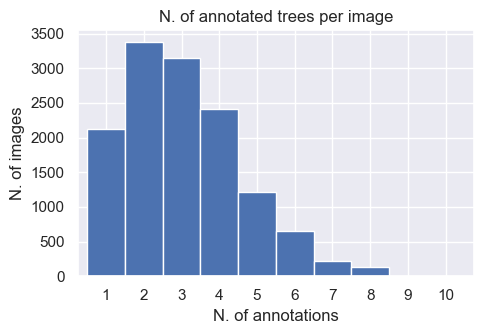

In [6]:
# Plot distribution
fig, ax = plt.subplots(figsize=(5, 3.5))
n_unique = len(np.unique(trees_per_img))
ax.hist(trees_per_img, bins=range(1, n_unique), align='left')
ax.set_xticks(ticks=range(1, n_unique+1))
ax.set_title('N. of annotated trees per image')
ax.set_xlim(min(trees_per_img) - .75, n_unique + .75)
ax.set_xlabel('N. of annotations')
ax.set_ylabel('N. of images')
plt.tight_layout()
# plt.savefig('../visualizations/trees_per_img.png', bbox_inches='tight', pad_inches=0)
plt.show()

### Get n. of images per tree

In [7]:
# Get n. of annotations per tree
imgs_per_tree = list(Counter(mappings['ann_to_tree'].values()).values())
imgs_per_tree += [0] * len(trees[(~trees['id'].isin(set(mappings['ann_to_tree'].values()))) & (~trees['split'].isnull())])

print(f'Min: {min(imgs_per_tree)} \nMax: {max(imgs_per_tree)} \nMean: {np.mean(imgs_per_tree):.1f}')

Min: 0 
Max: 9 
Mean: 2.1


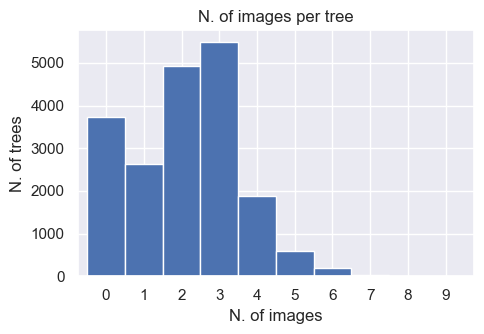

In [8]:
# Plot distribution
fig, ax = plt.subplots(figsize=(5, 3.5))
n_unique = len(np.unique(imgs_per_tree))
ax.hist(imgs_per_tree, bins=range(0, n_unique-1), align='left')
ax.set_title('N. of images per tree')
ax.set_xticks(ticks=range(0, n_unique))
ax.set_xlim(min(imgs_per_tree) - .75, n_unique-1 + .75)
ax.set_xlabel('N. of images')
ax.set_ylabel('N. of trees')
plt.tight_layout()
# plt.savefig('../visualizations/imgs_per_tree.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [9]:
print(f'Fraction of trees with more than 1 image: {round((len([n for n in imgs_per_tree if n > 1]) / len([n for n in imgs_per_tree if n > 0])) * 100)}% of trees with at least 1 image')
print(f'Fraction of trees with 0 images: {round((len([n for n in imgs_per_tree if n == 0]) / len(imgs_per_tree)) * 100)}% of all trees')

Fraction of trees with more than 1 image: 83% of trees with at least 1 image
Fraction of trees with 0 images: 19% of all trees


### Examine distribution of overlap between annotated bounding boxes


Min: 0.000 
Max: 0.631 
Mean: 0.155


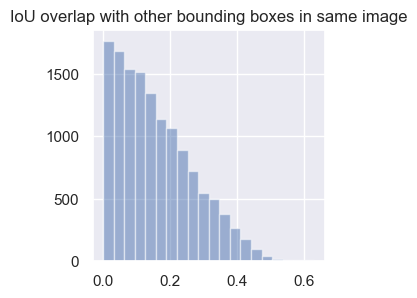

In [10]:
# Compute IoU for all overlapping bboxes
img_ids = [img['id'] for img in anns['images']]

overlaps_iou = []
for img_id in img_ids:
    anns_img = [ann for ann in anns['annotations'] if ann['image_id'] == img_id]
    for i, ann1 in enumerate(anns_img):
        for ann2 in anns_img[i+1:]:
            overlap_iou = iou(ann1['bbox'], ann2['bbox'])
            if overlap_iou > 0:
                overlaps_iou.append(overlap_iou)
    
print(f'\nMin: {min(overlaps_iou):.3f} \nMax: {max(overlaps_iou):.3f} \nMean: {np.mean(overlaps_iou):.3f}')
fig, ax = plt.subplots(figsize=(3, 3))
ax.hist(overlaps_iou, 20, alpha=0.5)
ax.set_title(f'IoU overlap with other bounding boxes in same image')
plt.show()

In [11]:
print(f'Percentage of IoU overlaps > 0.5: {(len([overlap for overlap in overlaps_iou if overlap > 0.5]) / len(overlaps_iou))*100:.2f}%')

Percentage of IoU overlaps > 0.5: 0.20%


### Get distribution of labels

In [4]:
# Get tree labels
k = 12
ann_to_tree_split = {ann_id: tree_id for ann_id, tree_id in mappings['ann_to_tree'].items() if tree_id in trees['id'].values}
top_k_species = list(trees.groupby('slaegt').size().sort_values(ascending=False).index)[:k]
tree_to_label = {tree['id']: tree['slaegt'] if tree['slaegt'] in top_k_species else 'OTHER' for _, tree in trees.iterrows()}
tree_ids = set(ann_to_tree_split.values())
labels_trees = [tree_to_label[tree_id] for tree_id in tree_ids]

# Sort by count
labels_trees_sorted = [label for label, count in Counter(labels_trees).most_common() for cat_name in [label] * count if cat_name != 'OTHER']
labels_trees_sorted = labels_trees_sorted + [label for label in labels_trees if label == 'OTHER']

# Get annotation labels
label_names = [label['name'] for label in anns['categories']]
label_ids_anns = [ann['category_id'] for ann in anns['annotations']]
labels_anns = np.array(label_names)[label_ids_anns]
labels_anns = [label for label in labels_anns if label in top_k_species] 
labels_anns += ['OTHER'] * (len(label_ids_anns) - len(labels_anns))

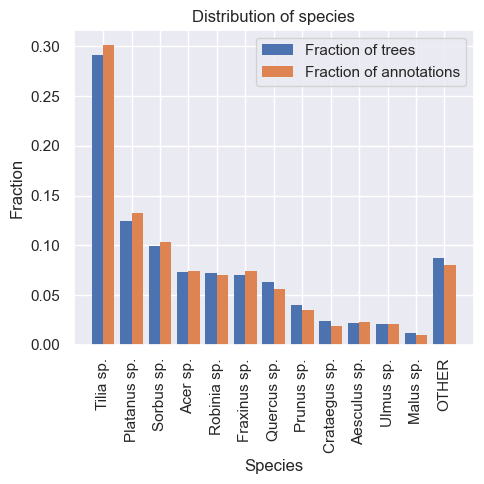

In [5]:
# Plot distribution of species
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
n_classes = len(np.unique(labels_trees_sorted))
n_anns = len(labels_trees_sorted)
ax.hist([labels_trees_sorted, labels_anns], bins=range(n_classes+1), align='left', density=True, edgecolor='none')
plt.xticks(ticks=range(n_classes), rotation=90)
ax.set_title(f'Distribution of species')
ax.set_xlabel('Species')
ax.set_ylabel('Fraction')
ax.legend(['Fraction of trees', 'Fraction of annotations'])
plt.tight_layout()
# plt.savefig(f'visualizations/class_distribution.png')
plt.show()

In [6]:
# Get number of annotations for each label
sorted(Counter(labels_anns).most_common(), key=lambda x: x[1], reverse=True)

[('Tilia sp.', 12265),
 ('Platanus sp.', 5386),
 ('Sorbus sp.', 4196),
 ('OTHER', 3270),
 ('Fraxinus sp.', 3045),
 ('Acer sp.', 3024),
 ('Robinia sp.', 2865),
 ('Quercus sp.', 2301),
 ('Prunus sp.', 1422),
 ('Aesculus sp.', 950),
 ('Ulmus sp.', 856),
 ('Crataegus sp.', 785),
 ('Malus sp.', 397)]

### Show examples of each tree species

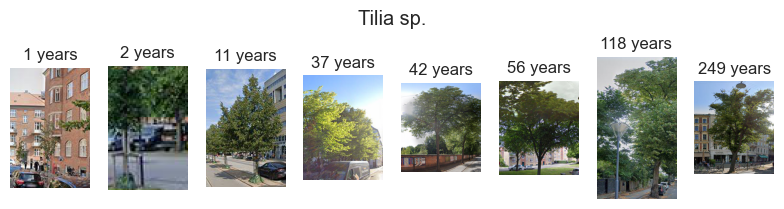

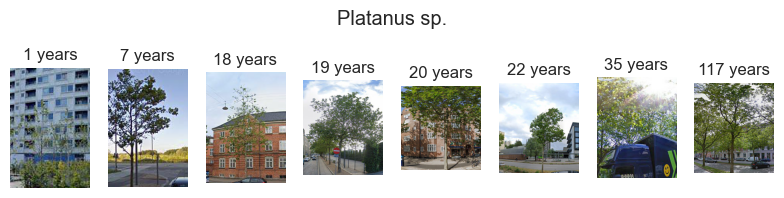

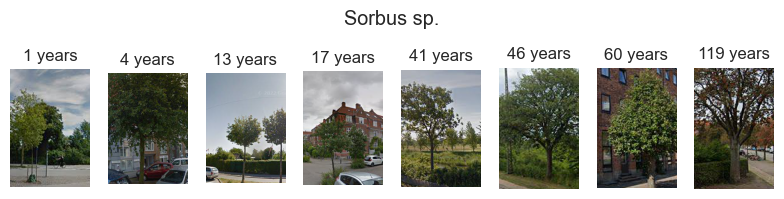

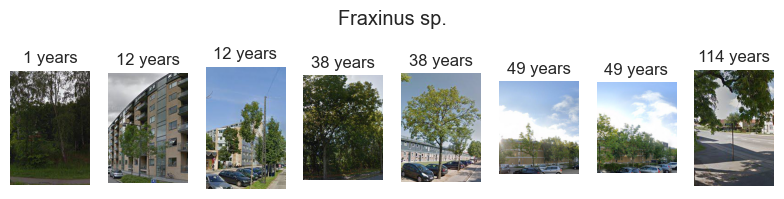

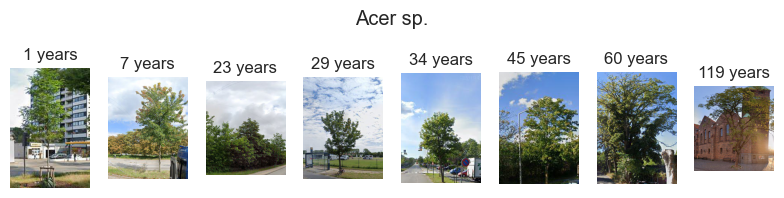

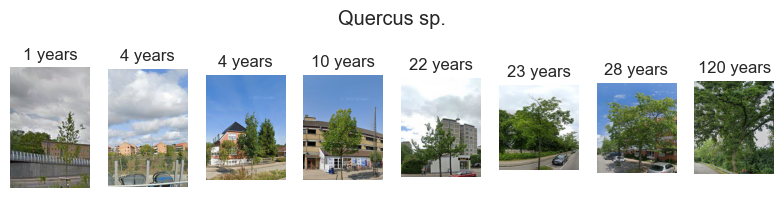

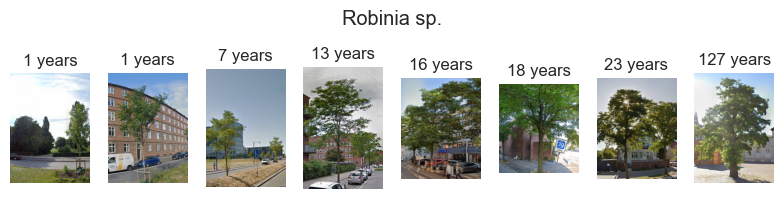

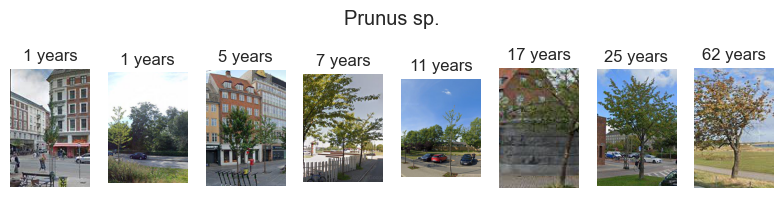

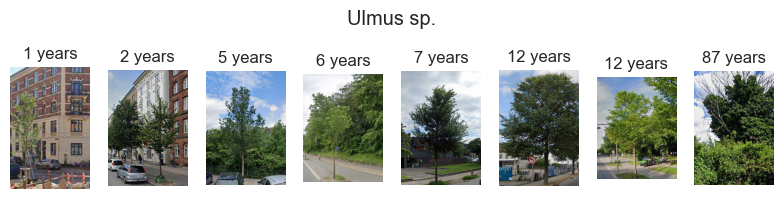

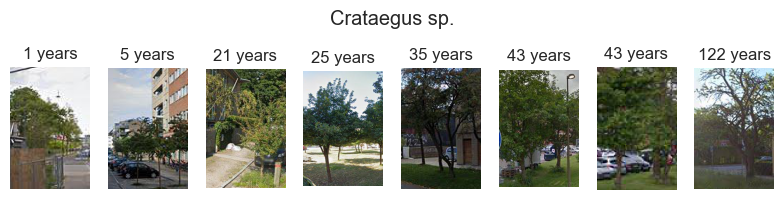

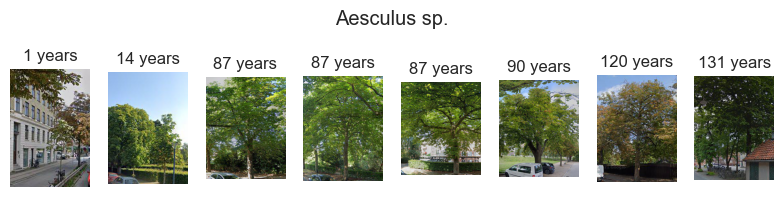

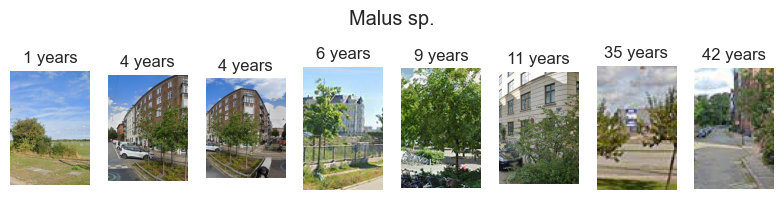

In [8]:
# Show examples of each label
for label_id, label_name in enumerate(label_names[:12]):
    anns_class = [ann for ann in anns['annotations'] if ann['category_id'] == label_id]

    # Choose number of images
    n_imgs = min(8, len(anns_class))
    if n_imgs < 2:
        continue

    # Compute ages of trees in images
    filenames, ages = [], []
    for ann in anns_class:
        filename = [img['file_name'] for img in anns['images'] if img['id'] == ann['image_id']][0]
        pano = panos[filename.split('.')[0]]
        tree_id = mappings['ann_to_tree'][str(ann['id'])]
        tree = trees[trees['id'] == tree_id].iloc[0]
        age = pano['Data']['image_date'][0] - tree['planteaar']
        filenames.append(filename)
        ages.append(age)

    # Choose random trees in the order of age
    indices_age = np.argsort(ages)
    filenames, ages, anns_class = [np.array(ar)[indices_age] for ar in [filenames, ages, anns_class]]
    indices_random = sample(range(1, len(ages)-1), n_imgs-2)
    indices_random = sorted(indices_random)
    indices_random = [0] + indices_random + [len(ages)-1]

    # Plot tree cutouts
    fig, axs = plt.subplots(1, n_imgs, figsize=(n_imgs, 2.5))
    for i, ax in zip(indices_random, axs):
        ann = anns_class[i]
        bbox = ann['bbox']
        im = Image.open(f'../data/streetviews/{filenames[i]}')
        x1, x2, y1, y2 = bbox[0], bbox[0]+bbox[2], bbox[1], bbox[1]+bbox[3]
        im_cropped = np.array(im)[max(round(y1), 0):round(y2), max(round(x1), 0):round(x2)]
        ax.imshow(im_cropped)
        ax.axis('off')
        ax.set_title(f'{ages[i]} years')
    plt.suptitle(label_name, y=0.9)
    fig.tight_layout()
    # plt.savefig(f'visualizations/species_all/{label_name}', bbox_inches='tight')
    plt.show()

### Show annotated images

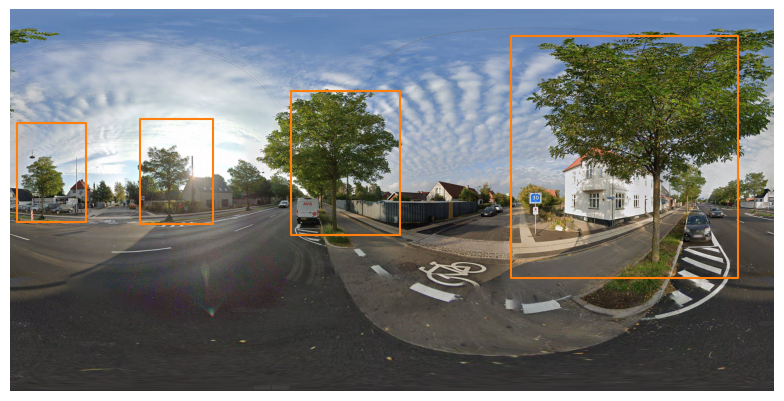

In [10]:
# Get all annotations in image
img_idx = 0
img = anns['images'][img_idx]
anns_img = [ann for ann in anns['annotations'] if ann['image_id'] == img['id']]
bboxes = [ann['bbox'] for ann in anns_img]

# Load image
filename = img['file_name']
im = Image.open(f'../data/streetviews/{filename}')

# Show labeled image
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')
ax.imshow(im)
show_anns(bboxes, ax)
# plt.savefig('../visualizations/annotated_img.png', bbox_inches='tight', pad_inches = 0)
plt.tight_layout()
plt.show()

### Show same tree in multiple images

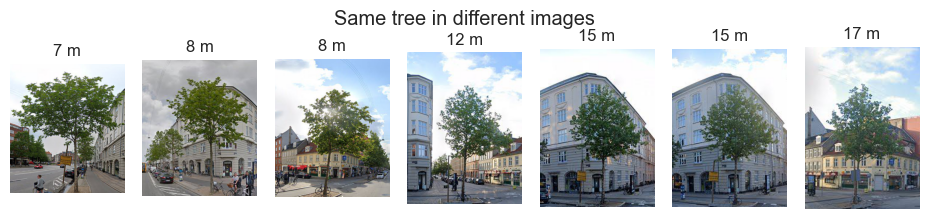

In [11]:
# Show same tree in multiple images
for _, tree in trees[trees['id'] == 11777].iterrows():#trees.sample(len(trees)).iterrows():
    anns_tree = [ann for ann in anns['annotations'] if mappings['ann_to_tree'][str(ann['id'])] == tree['id']]
    n_imgs = len(anns_tree)
    if n_imgs > 4:

        # Compute distance to tree in images
        filenames, dists = [], []
        for i in range(len(anns_tree)):
            ann = anns_tree[i]
            img_id = ann['image_id']
            filename = [img['file_name'] for img in anns['images'] if img['id'] == ann['image_id']][0]
            pano = panos[filename.split('.')[0]]
            filenames.append(filename)
            dist = haversine_distance(tree['lat'], tree['lng'], pano['Location']['lat'], pano['Location']['lng'])
            dists.append(dist)

        # Choose random trees in the order of age
        indices_dists = np.argsort(dists)

        # Plot tree cutouts
        fig, axs = plt.subplots(1, n_imgs, figsize=(1.35*n_imgs, 2.5))
        for i, ax in zip(indices_dists, axs):
            ann = anns_tree[i]
            bbox = ann['bbox']
            im = Image.open(f'../data/streetviews/{filenames[i]}')
            x1, x2, y1, y2 = bbox[0], bbox[0]+bbox[2], bbox[1], bbox[1]+bbox[3]
            im_cropped = np.array(im)[max(round(y1), 0):round(y2), max(round(x1), 0):round(x2)]
            ax.imshow(im_cropped)
            ax.axis('off')
            ax.set_title(f'{round(dists[i])} m')
        plt.suptitle('Same tree in different images', y=0.9)
        fig.tight_layout()
        # plt.savefig(f'../visualizations/same_tree_dif_imgs.png', bbox_inches='tight', pad_inches=0)
        plt.show()
        break

### Show removed trees

In [12]:
# Print statistics
tree_ids_kept = set(mappings['ann_to_tree'].values())
n_trees_removed = len(trees) - len(tree_ids_kept)
print(f'{n_trees_removed} ({round((n_trees_removed / len(trees)) * 100)}%) trees have been removed')

4099 (21%) trees have been removed


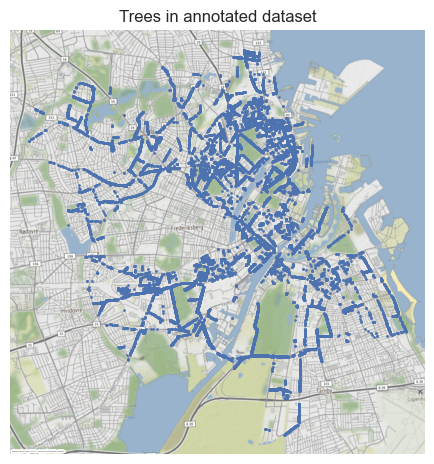

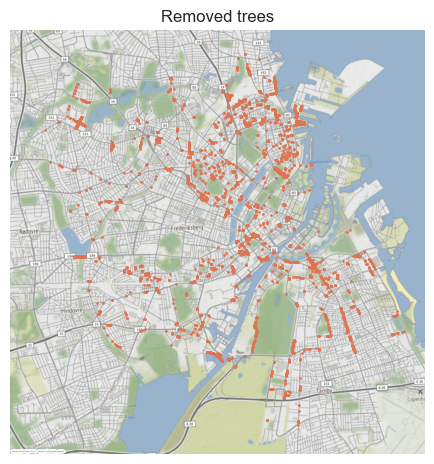

In [13]:
# Plot trees on map
trees_kept = trees[trees['id'].isin(tree_ids_kept)]
trees_removed = trees[~trees['id'].isin(tree_ids_kept)]
new_crs = 'epsg:25832'
color_palette = sns.color_palette()[:2]
color_palette[1] = [color_palette[1][0], 0.46, color_palette[1][2]]
titles = ['Trees in annotated dataset', 'Removed trees']
filenames = ['kept_trees_on_map.png', 'removed_trees_on_map.png']

for i, (trees_subset, color, title, filename) in enumerate(zip([trees_kept, trees_removed], color_palette, titles, filenames)):
    fig, ax = plt.subplots()
    trees_subset.to_crs(new_crs).plot(ax=ax, color=color, markersize=0.9, alpha=1)
    ax.set_axis_off()
    ax.set_title(title)
    cx.add_basemap(ax=ax, crs=new_crs, attribution_size=0)
    if i == 0:
        x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
    else:
        ax.set_xlim(x_lim), ax.set_ylim(y_lim)
    plt.tight_layout()
    # plt.savefig(f'../visualizations/{filename}', bbox_inches='tight', pad_inches=0)
    plt.show()

### Examine distribution of sizes of the annotated bboxes

	Width: 
		Min: 39.00 
		Max: 847.00 
		Mean: 240.28
	Height: 
		Min: 61.00 
		Max: 709.00 
		Mean: 296.65
	Ratio: 
		Min: 0.82 
		Max: 1.55 
		Mean: 1.31


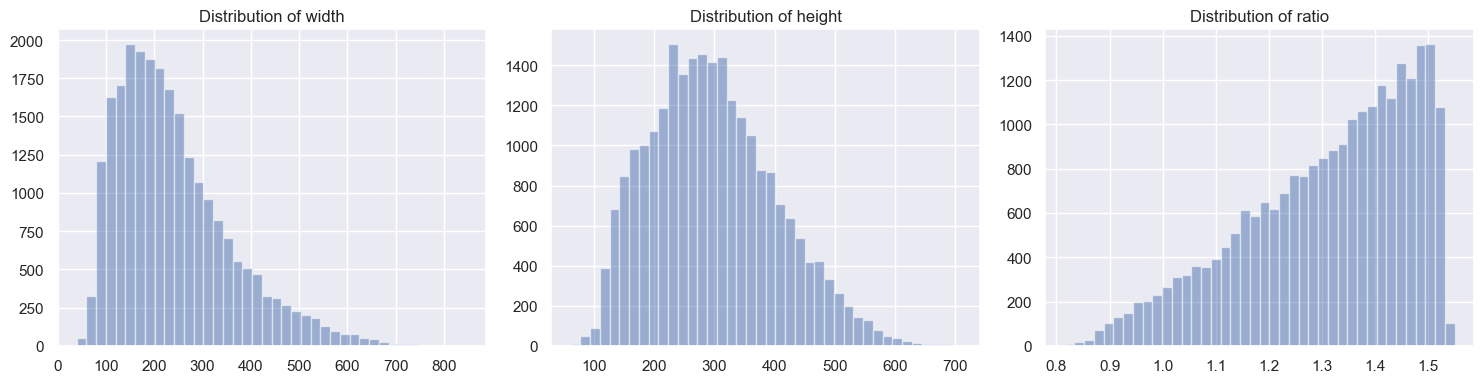

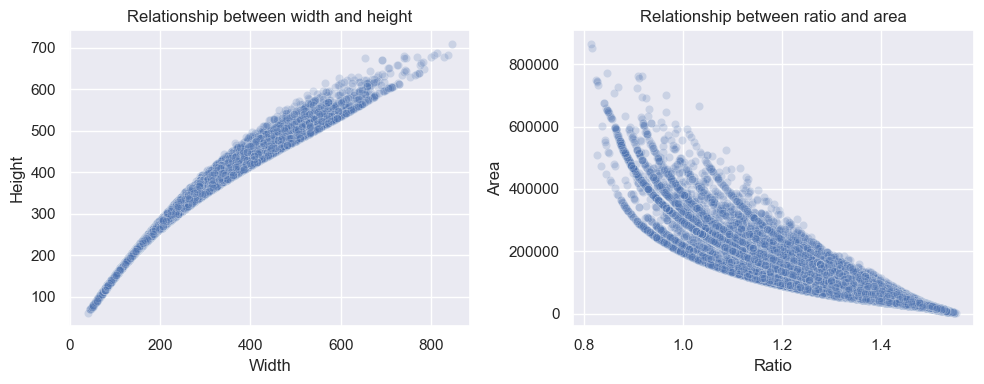

In [15]:
split = 'train'
with open(f'../data/annotations/annotations_{split}.json', 'r') as fp:
    anns = json.load(fp)

img_ids = [ann['image_id'] for ann in anns['annotations']]
imgs = [[img for img in anns['images'] if img['id'] == img_id][0] for img_id in img_ids]
img_sizes = [(img['width'], img['height']) for img in imgs]
widths = [ann['bbox'][2] for ann in anns['annotations']]
heights = [ann['bbox'][3] for ann in anns['annotations']]
ratios = np.array(heights) / np.array(widths)
areas = np.array(widths) * np.array(heights)
dim_names = ['Width', 'Height', 'Ratio']

img_size_after = [1664, 832]
scales_1 = [(np.array(img_size_after)/np.array(img_size))[0] for img_size in img_sizes]
widths, heights = [[int(np.ceil(value*scale_1)) for value, scale_1 in zip(dim, scales_1)] for dim in [widths, heights]]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for ax, dim, dim_name in zip(axs, [widths, heights, ratios], dim_names):
    print(f'\t{dim_name.capitalize()}: \n\t\tMin: {min(dim):.2f} \n\t\tMax: {max(dim):.2f} \n\t\tMean: {np.mean(dim):.2f}')
    ax.hist(dim, bins=40, alpha=0.5)
    ax.set_title(f'Distribution of {dim_name.lower()}')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, dims, dim_names in zip(axs, [[widths, heights], [ratios, areas]], [['Width', 'Height'], ['Ratio', 'Area']]):
    sns.scatterplot(x=dims[0], y=dims[1], alpha=0.2, ax=ax)
    ax.set_xlabel(dim_names[0])
    ax.set_ylabel(dim_names[1])
    ax.set_title(f'Relationship between {dim_names[0].lower()} and {dim_names[1].lower()}')
plt.tight_layout()
plt.show()

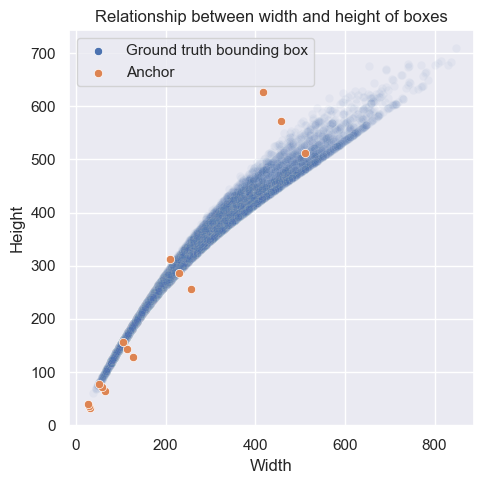

In [16]:
# Compute anchor sizes
bbox_sizes = []
scale = 8
for stride in np.array([4, 8, 16, 32, 64]):
    for ratio in [1, 1.25, 1.5]:
        h_ratio = np.sqrt(ratio)
        w_ratio = 1 / h_ratio
        bbox_sizes.append((stride * scale * w_ratio, stride * scale * h_ratio))

# Plot anchor sizes compared to ground truth bounding box sizes

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=widths, y=heights, alpha=0.05, ax=ax, label='Ground truth bounding box')
sns.scatterplot(x=[e[0] for e in bbox_sizes], y=[e[1] for e in bbox_sizes], ax=ax, label='Anchor')
plt.xlabel('Width')
plt.ylabel('Height')
plt.title(f'Relationship between width and height of boxes')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
# plt.savefig(f'../visualizations/bbox_anchor_sizes.png', bbox_inches='tight', pad_inches=0)
plt.show()

Stride: X-axis  
Ratio: Angle from (0,0)  
Scale: Distance from (0,0)

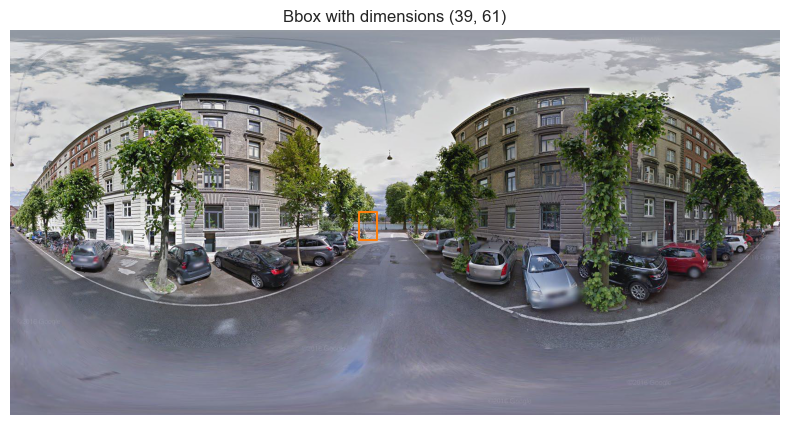

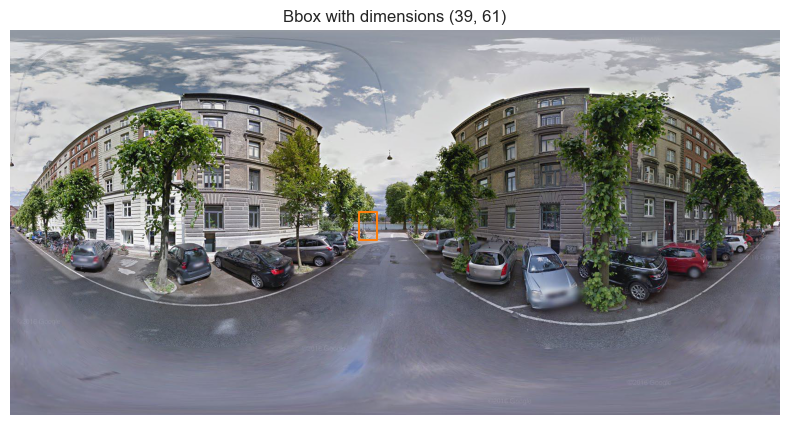

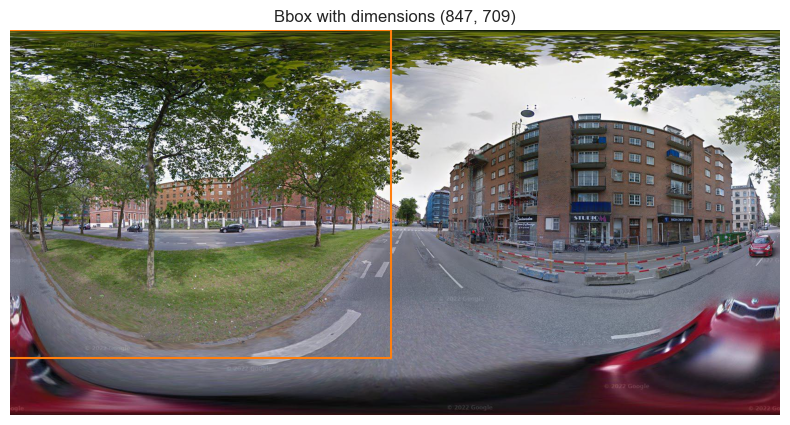

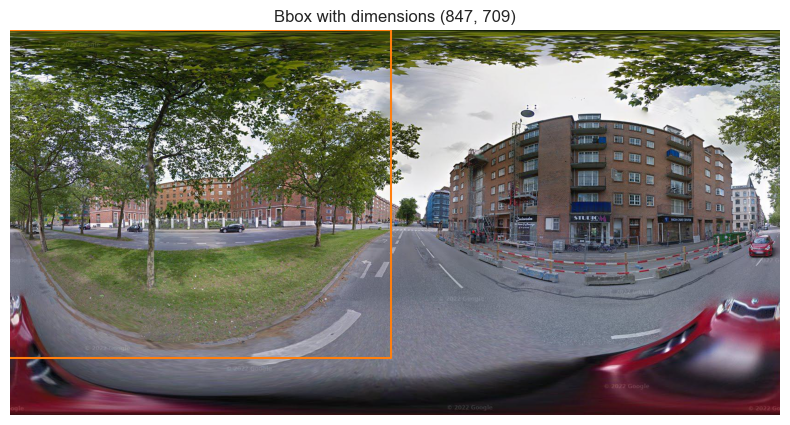

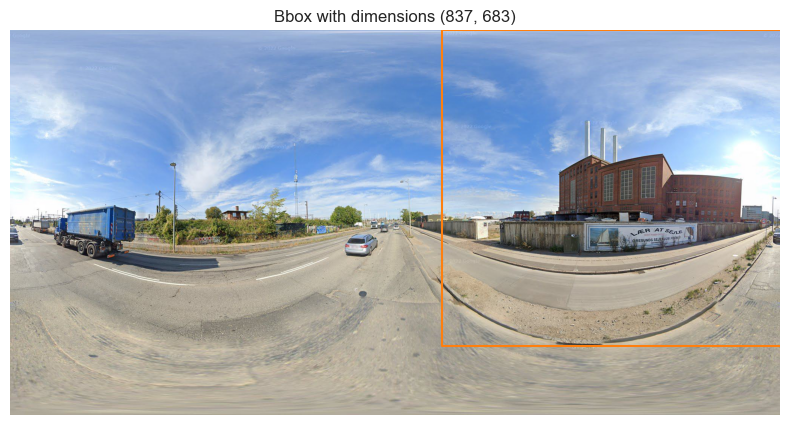

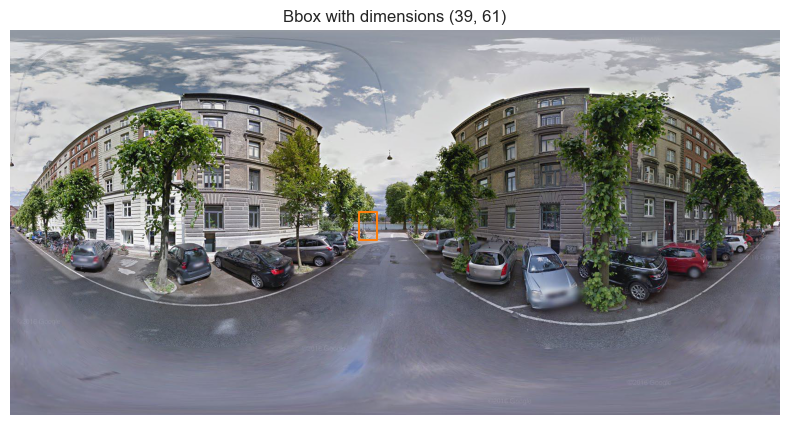

In [17]:
# Show streetview image(s) with bboxes with the shortest and longest width, height, and ratio
for ann_idx in [np.argmin(widths), np.argmin(heights), np.argmax(widths), np.argmax(heights), np.argmin(ratios), np.argmax(ratios)]:
    # Get annotation, image, width, and height
    ann = anns['annotations'][ann_idx]
    img = [img for img in anns['images'] if img['id'] == ann['image_id']][0]
    img_size = (img['width'], img['height'])
    scale_1 = (np.array(img_size_after) / np.array(img_size))[0]
    width = int(np.ceil(ann['bbox'][2] * scale_1))
    height = int(np.ceil(ann['bbox'][3] * scale_1))
    
    # Show annotation on image
    im = Image.open(f'../data/streetviews/{img["file_name"]}')
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(im)
    ax.axis('off')
    y_coor1 = ann['bbox'][1]
    y_coor2 = y_coor1+height
    ax.set_title(f'Bbox with dimensions ({width}, {height})')
    show_anns([ann['bbox']], ax)
    plt.show()